## Import Library dan Setup Lingkungan


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
import warnings
import pickle
import time
import os
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, RegressorMixin

## Memuat Data


In [28]:
# Muat data
train_df = pd.read_csv('dataset/data_iph_training.csv')
test_df = pd.read_csv('dataset/data_iph_testing.csv')
full_df = pd.read_csv('data_iph_modeling.csv')

# Konversi kolom tanggal ke datetime jika belum
train_df['Tanggal'] = pd.to_datetime(train_df['Tanggal'])
test_df['Tanggal'] = pd.to_datetime(test_df['Tanggal'])
full_df['Tanggal'] = pd.to_datetime(full_df['Tanggal'])

# Pisahkan fitur (X) dan target (y)
FEATURE_COLS = ['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'MA_3', 'MA_7']
TARGET_COL = 'Indikator_Harga'

X_train = train_df[FEATURE_COLS].values
y_train = train_df[TARGET_COL].values

X_test = test_df[FEATURE_COLS].values
y_test = test_df[TARGET_COL].values

print("Data berhasil dimuat dan dipisahkan.")
print(f"Jumlah data training: {len(X_train)}")
print(f"Jumlah data testing: {len(X_test)}")

# Buat folder untuk menyimpan model
model_folder = 'saved_models'
if not os.path.exists(model_folder):
    os.makedirs(model_folder)
    print(f"Folder '{model_folder}' telah dibuat.")

Data berhasil dimuat dan dipisahkan.
Jumlah data training: 89
Jumlah data testing: 23


## Fungsi untuk forecasting multi-step


In [29]:
def forecast_multistep(model, last_data, n_steps, feature_cols):
    """
    Melakukan forecasting multi-step ahead
    """
    predictions = []
    current_features = last_data.copy()
    
    for step in range(n_steps):
        # Prediksi satu langkah ke depan
        pred = model.predict(current_features.reshape(1, -1))[0]
        predictions.append(pred)
        
        # Update features untuk langkah berikutnya
        # Shift lag features
        new_features = np.zeros_like(current_features)
        new_features[0] = pred  # Lag_1
        for i in range(1, 4):  # Lag_2, Lag_3, Lag_4
            if i < len(current_features):
                new_features[i] = current_features[i-1]
        
        # Update moving averages (simplified - menggunakan nilai terakhir)
        new_features[4] = np.mean([pred, current_features[0], current_features[1]])  # MA_3
        new_features[5] = np.mean(current_features[:4])  # MA_7 (simplified)
        
        current_features = new_features
    
    return np.array(predictions)

## Custom XGBoost Class dengan Optimasi


In [30]:
class XGBoostAdvanced(BaseEstimator, RegressorMixin):
    def __init__(self):
        # Parameter yang sudah dioptimasi untuk forecasting
        self.n_estimators = 200
        self.learning_rate = 0.05
        self.max_depth = 4
        self.min_child_weight = 3
        self.subsample = 0.8
        self.colsample_bytree = 0.8
        self.reg_alpha = 0.1
        self.reg_lambda = 0.1
        self.random_state = 42
        self.model = None
        
    def fit(self, X, y):
        # Inisialisasi XGBoost Advanced
        self.model = XGBRegressor(
            n_estimators=self.n_estimators,
            learning_rate=self.learning_rate,
            max_depth=self.max_depth,
            min_child_weight=self.min_child_weight,
            subsample=self.subsample,
            colsample_bytree=self.colsample_bytree,
            reg_alpha=self.reg_alpha,
            reg_lambda=self.reg_lambda,
            random_state=self.random_state,
            verbosity=0
        )
        
        # Fit model
        self.model.fit(X, y)
        return self
    
    def predict(self, X):
        return self.model.predict(X)
    
    def get_feature_importance(self):
        if self.model:
            return self.model.feature_importances_
        return None
    
    def get_params(self, deep=True):
        return {
            'n_estimators': self.n_estimators,
            'learning_rate': self.learning_rate,
            'max_depth': self.max_depth,
            'min_child_weight': self.min_child_weight,
            'subsample': self.subsample,
            'colsample_bytree': self.colsample_bytree,
            'reg_alpha': self.reg_alpha,
            'reg_lambda': self.reg_lambda,
            'random_state': self.random_state
        }

## Fungsi untuk Menyimpan Model Individual


In [31]:
def save_individual_model(model, model_name, model_info, folder='saved_models'):
    """
    Menyimpan model individual dengan informasi lengkap
    """
    model_data = {
        'model': model,
        'model_name': model_name,
        'model_info': model_info,
        'feature_cols': FEATURE_COLS,
        'target_col': TARGET_COL,
        'training_timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    # Nama file yang aman (ganti spasi dan karakter khusus)
    safe_name = model_name.replace(' ', '_').replace('/', '_').replace('\\', '_')
    filename = f"{folder}/{safe_name}.pkl"
    
    try:
        with open(filename, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"✓ Model '{model_name}' disimpan ke: {filename}")
        return filename
    except Exception as e:
        print(f"✗ Error menyimpan model '{model_name}': {str(e)}")
        return None


## Fungsi untuk Load Model Individual


In [32]:
def load_individual_model(model_name, folder='saved_models'):
    """
    Memuat model individual berdasarkan nama
    """
    safe_name = model_name.replace(' ', '_').replace('/', '_').replace('\\', '_')
    filename = f"{folder}/{safe_name}.pkl"
    
    try:
        with open(filename, 'rb') as f:
            model_data = pickle.load(f)
        
        print(f"✓ Model '{model_name}' berhasil dimuat dari: {filename}")
        return model_data
    
    except FileNotFoundError:
        print(f"✗ File model '{model_name}' tidak ditemukan: {filename}")
        return None
    except Exception as e:
        print(f"✗ Error memuat model '{model_name}': {str(e)}")
        return None

## Fungsi untuk Prediksi dengan Model yang Dimuat


In [33]:
def predict_with_loaded_model(model_name, X_input, folder='saved_models'):
    """
    Prediksi menggunakan model yang dimuat
    """
    model_data = load_individual_model(model_name, folder)
    
    if model_data:
        model = model_data['model']
        prediction = model.predict(X_input)
        return prediction, model_data['model_info']
    
    return None, None

## Modeling dan Evaluasi pada Test Set


In [34]:
models = {
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=4, min_samples_leaf=3, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, num_leaves=15, 
                              reg_alpha=0.1, reg_lambda=0.1, random_state=42, verbose=-1),
    'XGBoost_Advanced': XGBoostAdvanced()  # Hanya XGBoost Advanced
}

# Simpan hasil performa dan model
results = []
trained_models = {}
saved_model_files = {}

print("\nMemulai eksperimen model...")
print("=" * 60)

for name, model in models.items():
    try:
        print(f"Training model: {name}")
        start_time = time.time()
        
        # Fit model
        model.fit(X_train, y_train)
        
        # Prediksi
        y_pred = model.predict(X_test)
        
        # Evaluasi
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        # Waktu training
        training_time = time.time() - start_time
        
        # Informasi model
        model_info = {
            'MAE': mae,
            'RMSE': rmse,
            'R²': r2,
            'Training_Time': training_time,
            'Model_Type': type(model).__name__,
            'Parameters': model.get_params() if hasattr(model, 'get_params') else 'N/A'
        }
        
        results.append({
            'Model': name, 
            'MAE': mae, 
            'RMSE': rmse, 
            'R²': r2,
            'Training_Time': training_time
        })
        
        # Simpan model ke memori
        trained_models[name] = model
        
        # Simpan model ke file individual
        saved_file = save_individual_model(model, name, model_info)
        if saved_file:
            saved_model_files[name] = saved_file
        
        print(f"✓ {name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}, Time: {training_time:.2f}s")
        
    except Exception as e:
        print(f"✗ Error dengan {name}: {str(e)}")
        continue

# Tampilkan hasil dalam bentuk tabel
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('MAE').reset_index(drop=True)

print("\n" + "=" * 80)
print("HASIL PERBANDINGAN MODEL")
print("=" * 80)
print(results_df.to_string(index=False))


Memulai eksperimen model...
Training model: KNN
✓ Model 'KNN' disimpan ke: saved_models/KNN.pkl
✓ KNN - MAE: 1.1255, RMSE: 1.4904, R²: 0.6401, Time: 0.00s
Training model: Random Forest
✓ Model 'Random Forest' disimpan ke: saved_models/Random_Forest.pkl
✓ Random Forest - MAE: 0.9674, RMSE: 1.3397, R²: 0.7092, Time: 0.11s
Training model: LightGBM
✓ Model 'LightGBM' disimpan ke: saved_models/LightGBM.pkl
✓ LightGBM - MAE: 1.1514, RMSE: 1.5949, R²: 0.5879, Time: 0.01s
Training model: XGBoost_Advanced
✓ Model 'XGBoost_Advanced' disimpan ke: saved_models/XGBoost_Advanced.pkl
✓ XGBoost_Advanced - MAE: 0.9510, RMSE: 1.1952, R²: 0.7686, Time: 0.11s

HASIL PERBANDINGAN MODEL
           Model      MAE     RMSE       R²  Training_Time
XGBoost_Advanced 0.951040 1.195217 0.768568       0.113105
   Random Forest 0.967375 1.339674 0.709244       0.114128
             KNN 1.125513 1.490438 0.640119       0.001999
        LightGBM 1.151359 1.594883 0.587914       0.014085


## Feature Importance Analysis untuk XGBoost Advanced



ANALISIS FEATURE IMPORTANCE XGBOOST ADVANCED


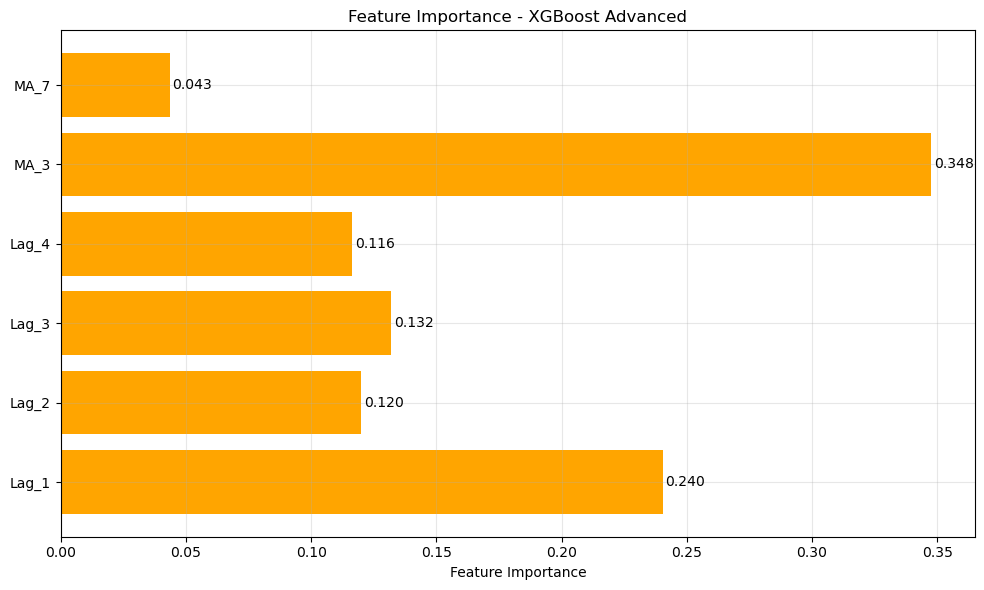


Feature Importance Ranking:
Feature  Importance
   MA_3    0.347671
  Lag_1    0.240499
  Lag_3    0.132027
  Lag_2    0.120044
  Lag_4    0.116365
   MA_7    0.043394

✓ Feature importance disimpan ke: 'xgboost_feature_importance.csv'


In [35]:
print(f"\n{'='*60}")
print("ANALISIS FEATURE IMPORTANCE XGBOOST ADVANCED")
print(f"{'='*60}")

if 'XGBoost_Advanced' in trained_models:
    xgb_model = trained_models['XGBoost_Advanced']
    feature_importance = xgb_model.get_feature_importance()
    
    if feature_importance is not None:
        # Visualisasi Feature Importance
        plt.figure(figsize=(10, 6))
        plt.barh(FEATURE_COLS, feature_importance, color='orange')
        plt.xlabel('Feature Importance')
        plt.title('Feature Importance - XGBoost Advanced')
        plt.grid(True, alpha=0.3)
        
        # Tampilkan nilai importance
        for i, v in enumerate(feature_importance):
            plt.text(v + 0.001, i, f'{v:.3f}', va='center', fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
        # Tabel feature importance
        importance_df = pd.DataFrame({
            'Feature': FEATURE_COLS,
            'Importance': feature_importance
        }).sort_values('Importance', ascending=False)
        
        print("\nFeature Importance Ranking:")
        print(importance_df.to_string(index=False))
        
        # Simpan feature importance
        importance_df.to_csv('xgboost_feature_importance.csv', index=False)
        print(f"\n✓ Feature importance disimpan ke: 'xgboost_feature_importance.csv'")


## Visualisasi Performa Model


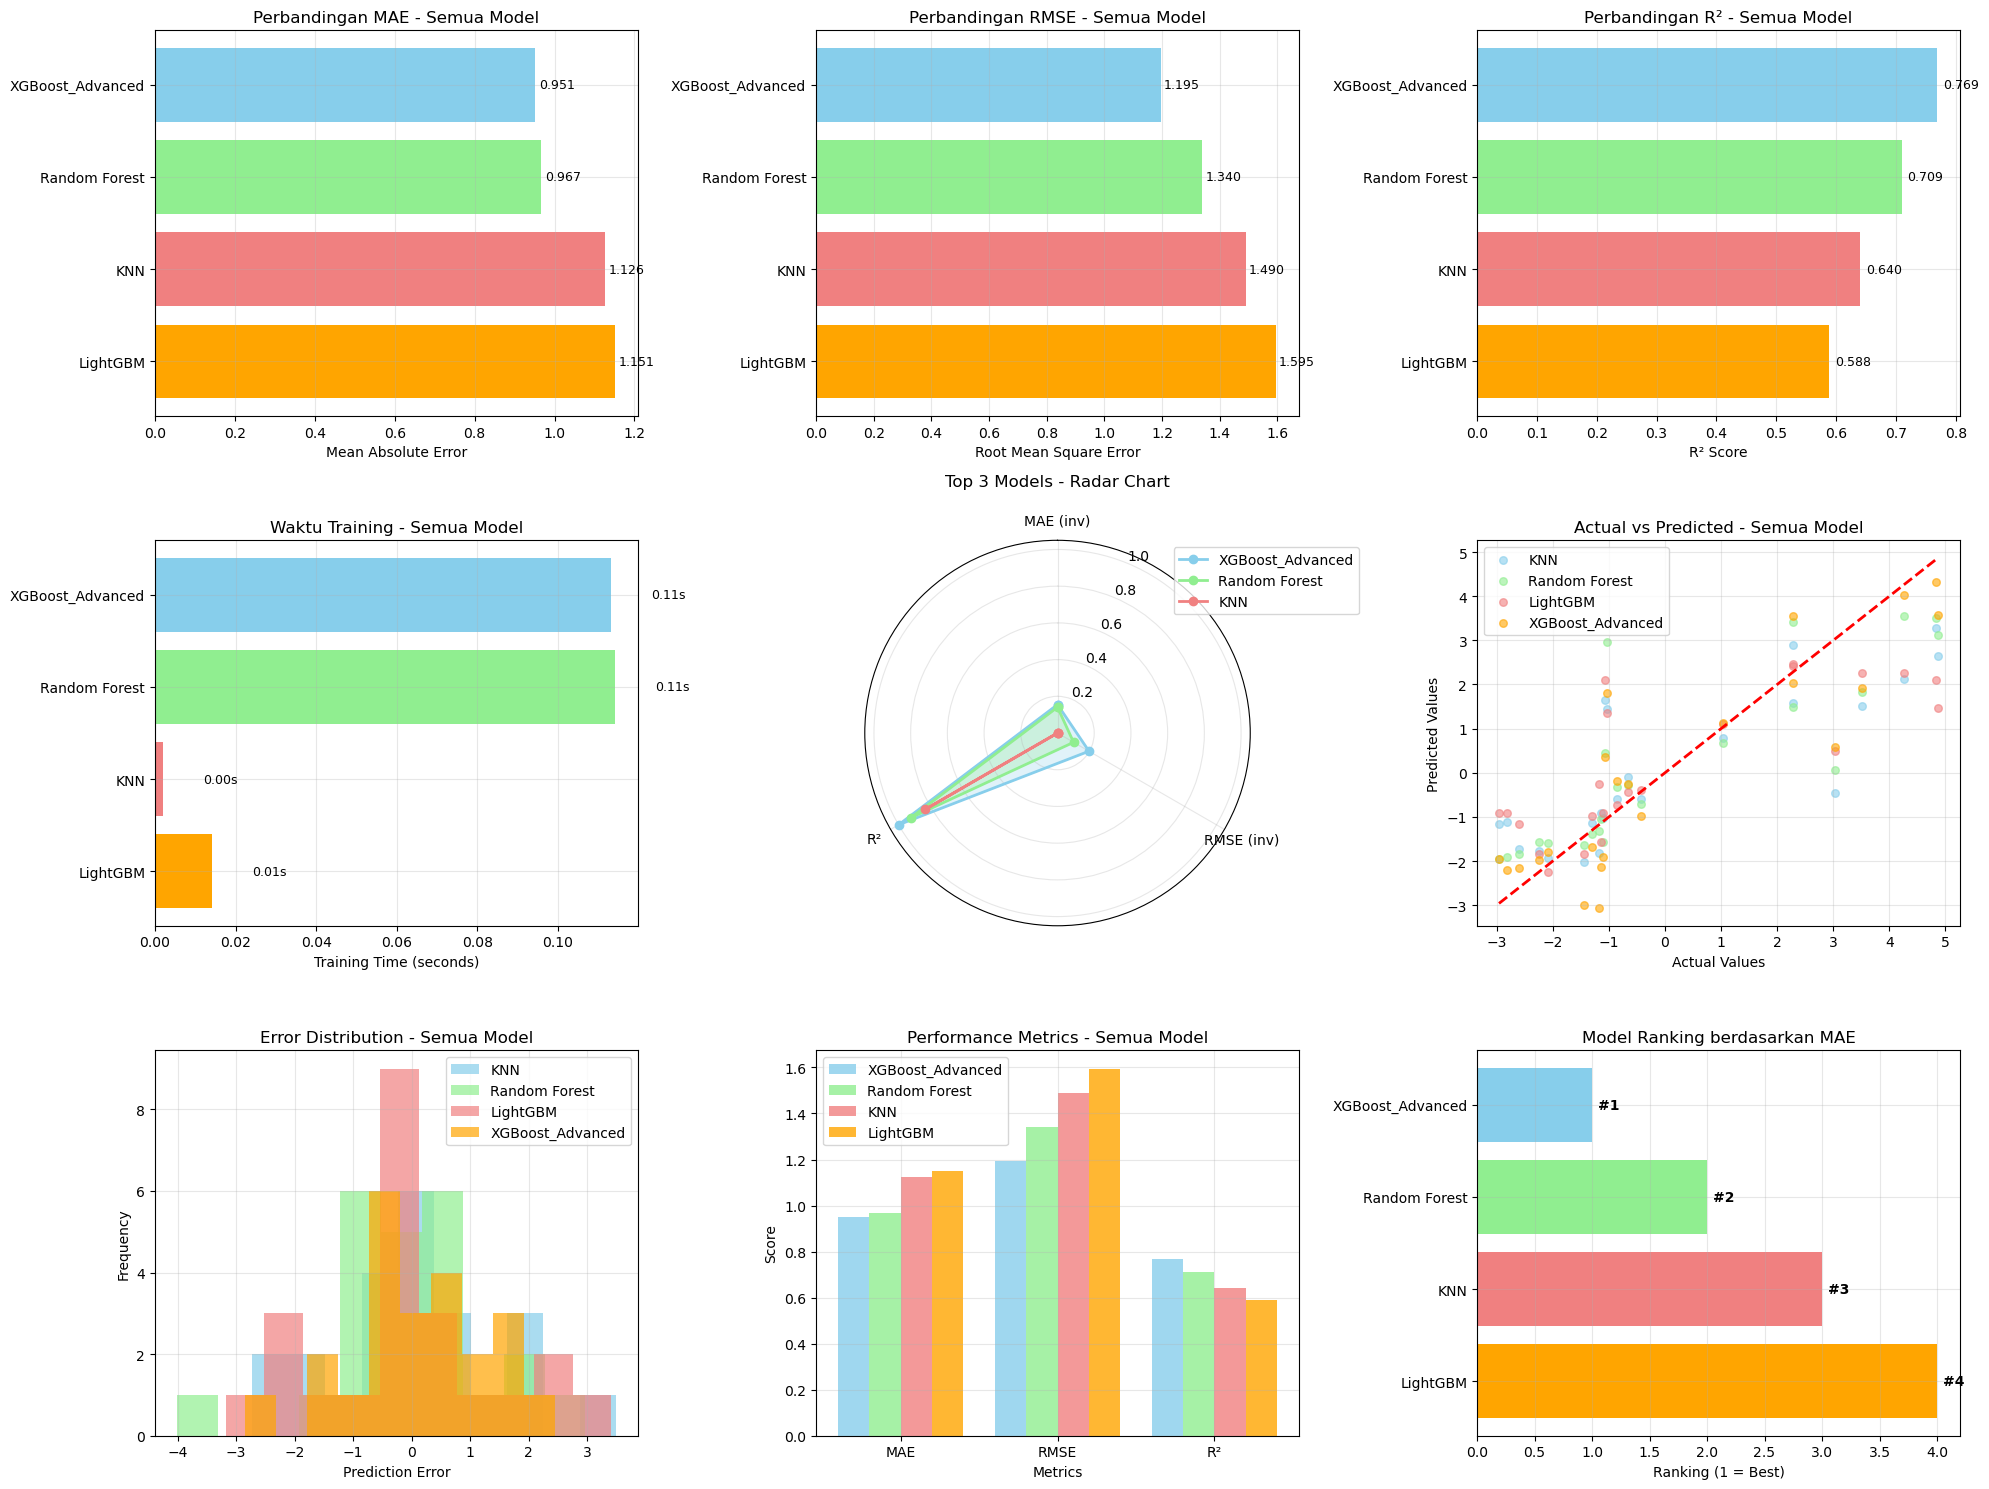

In [37]:
plt.figure(figsize=(20, 15))

# Plot 1: Perbandingan MAE
plt.subplot(3, 3, 1)
colors = ['skyblue', 'lightgreen', 'lightcoral', 'orange']
plt.barh(results_df['Model'], results_df['MAE'], color=colors)
plt.xlabel('Mean Absolute Error')
plt.title('Perbandingan MAE - Semua Model')
plt.gca().invert_yaxis()

# Tambahkan nilai pada bar
for i, v in enumerate(results_df['MAE']):
    plt.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

# Plot 2: Perbandingan RMSE
plt.subplot(3, 3, 2)
plt.barh(results_df['Model'], results_df['RMSE'], color=colors)
plt.xlabel('Root Mean Square Error')
plt.title('Perbandingan RMSE - Semua Model')
plt.gca().invert_yaxis()

# Tambahkan nilai pada bar
for i, v in enumerate(results_df['RMSE']):
    plt.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

# Plot 3: Perbandingan R²
plt.subplot(3, 3, 3)
plt.barh(results_df['Model'], results_df['R²'], color=colors)
plt.xlabel('R² Score')
plt.title('Perbandingan R² - Semua Model')
plt.gca().invert_yaxis()

# Tambahkan nilai pada bar
for i, v in enumerate(results_df['R²']):
    plt.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

# Plot 4: Training Time
plt.subplot(3, 3, 4)
plt.barh(results_df['Model'], results_df['Training_Time'], color=colors)
plt.xlabel('Training Time (seconds)')
plt.title('Waktu Training - Semua Model')
plt.gca().invert_yaxis()

# Tambahkan nilai pada bar
for i, v in enumerate(results_df['Training_Time']):
    plt.text(v + 0.01, i, f'{v:.2f}s', va='center', fontsize=9)

# Plot 5: Radar Chart untuk Top 3 Models - DIPERBAIKI
plt.subplot(3, 3, 5, projection='polar')  # Tambahkan projection='polar'
top_3_models = results_df.head(3)

# Normalisasi metrics untuk radar chart
mae_norm = 1 - (top_3_models['MAE'] / top_3_models['MAE'].max())
rmse_norm = 1 - (top_3_models['RMSE'] / top_3_models['RMSE'].max())
r2_norm = top_3_models['R²'] / top_3_models['R²'].max()

angles = np.linspace(0, 2 * np.pi, 3, endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

fig_radar = plt.gca()
fig_radar.set_theta_offset(np.pi / 2)
fig_radar.set_theta_direction(-1)
fig_radar.set_thetagrids(np.degrees(angles[:-1]), ['MAE (inv)', 'RMSE (inv)', 'R²'])

for i, (idx, model) in enumerate(top_3_models.iterrows()):
    values = [mae_norm.iloc[i], rmse_norm.iloc[i], r2_norm.iloc[i]]
    values += values[:1]  # Complete the circle
    
    fig_radar.plot(angles, values, 'o-', linewidth=2, label=model['Model'], color=colors[i])
    fig_radar.fill(angles, values, alpha=0.25, color=colors[i])

plt.title('Top 3 Models - Radar Chart', pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

# Plot 6: Actual vs Predicted untuk semua model
plt.subplot(3, 3, 6)
for i, (name, model) in enumerate(trained_models.items()):
    y_pred = model.predict(X_test)
    plt.scatter(y_test, y_pred, alpha=0.6, label=name, color=colors[i], s=30)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted - Semua Model')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 7: Error Distribution
plt.subplot(3, 3, 7)
for i, (name, model) in enumerate(trained_models.items()):
    y_pred = model.predict(X_test)
    errors = y_test - y_pred
    plt.hist(errors, bins=10, alpha=0.7, label=name, color=colors[i])

plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Error Distribution - Semua Model')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 8: Performance Metrics Comparison
plt.subplot(3, 3, 8)
metrics = ['MAE', 'RMSE', 'R²']
x = np.arange(len(metrics))
width = 0.2

for i, (idx, model) in enumerate(results_df.iterrows()):
    values = [model['MAE'], model['RMSE'], model['R²']]
    plt.bar(x + i * width, values, width, label=model['Model'], color=colors[i], alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Metrics - Semua Model')
plt.xticks(x + width * 1.5, metrics)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 9: Model Ranking
plt.subplot(3, 3, 9)
rankings = range(1, len(results_df) + 1)
plt.barh(results_df['Model'], rankings, color=colors)
plt.xlabel('Ranking (1 = Best)')
plt.title('Model Ranking berdasarkan MAE')
plt.gca().invert_yaxis()

# Tambahkan ranking pada bar
for i, v in enumerate(rankings):
    plt.text(v + 0.05, i, f'#{v}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## Forecasting ke Depan



--- Memproses Model: KNN ---


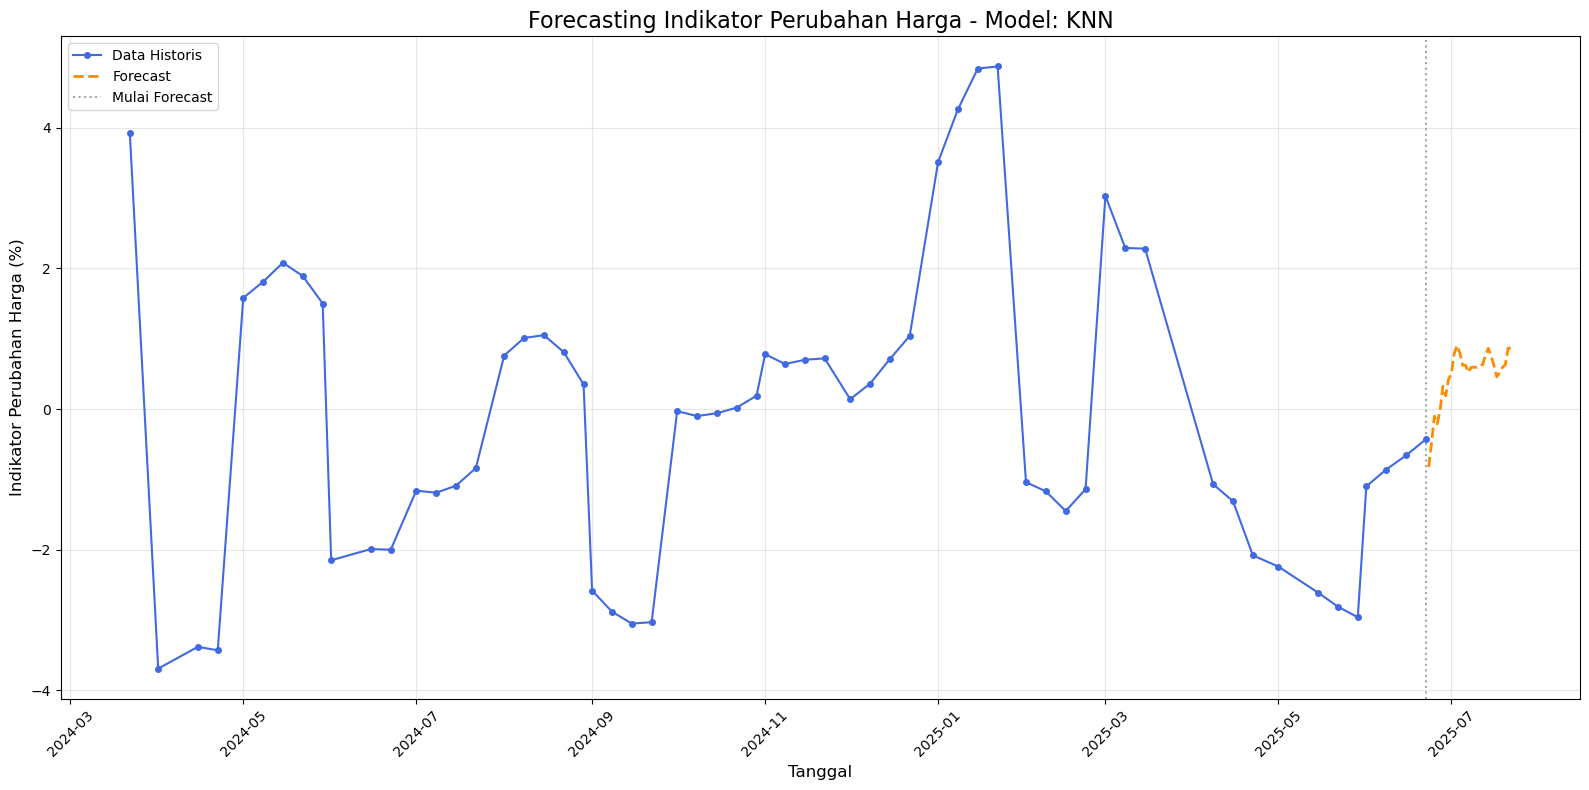


Statistik Forecast KNN:
Rata-rata forecast: 0.47
Std forecast: 0.41
Min forecast: -0.83
Max forecast: 0.90
Trend: Naik

--- Memproses Model: Random Forest ---


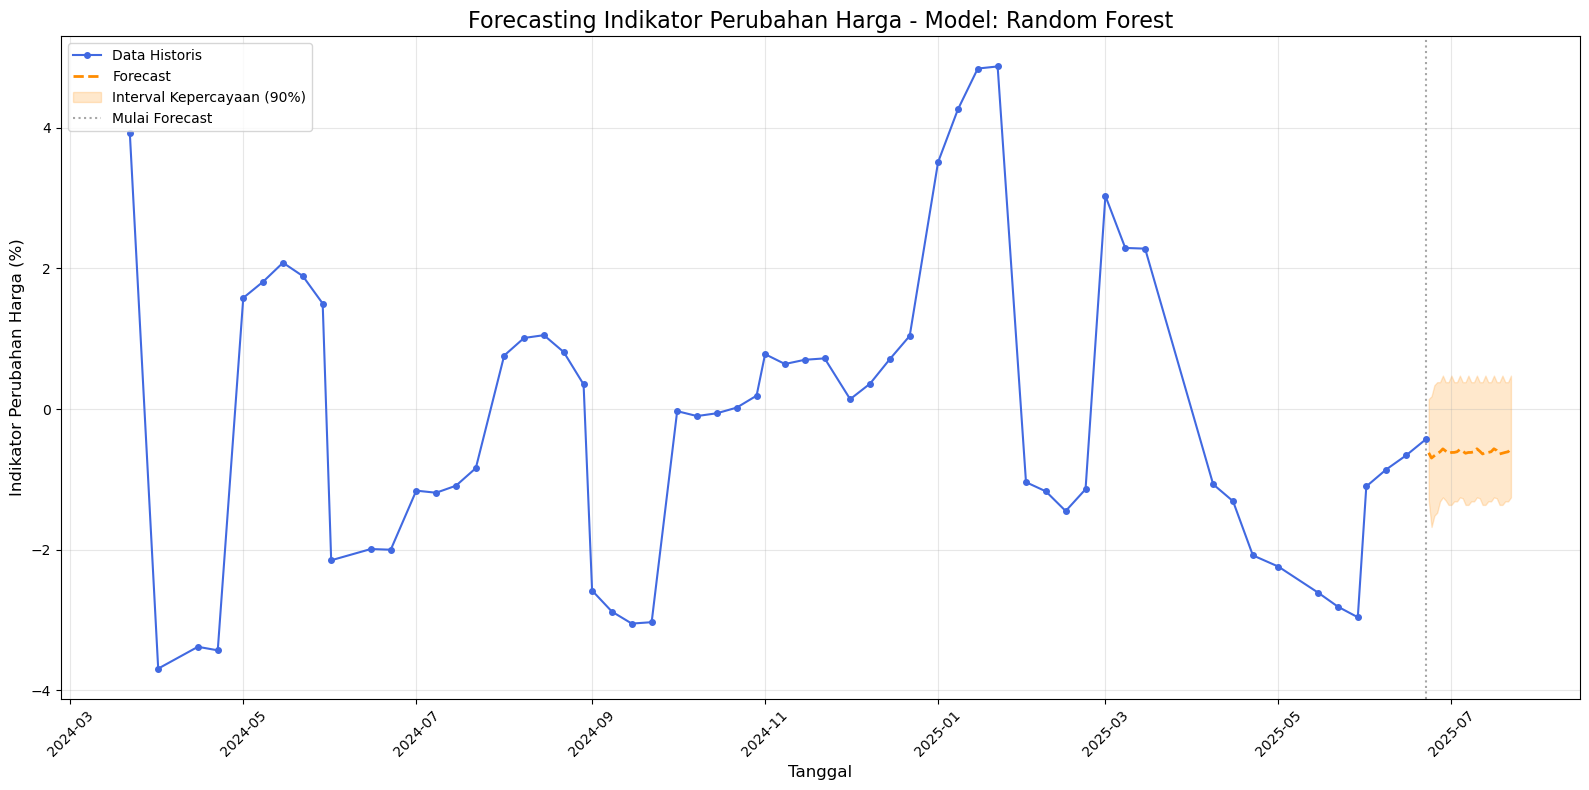


Statistik Forecast Random Forest:
Rata-rata forecast: -0.61
Std forecast: 0.03
Min forecast: -0.70
Max forecast: -0.56
Trend: Naik

--- Memproses Model: LightGBM ---


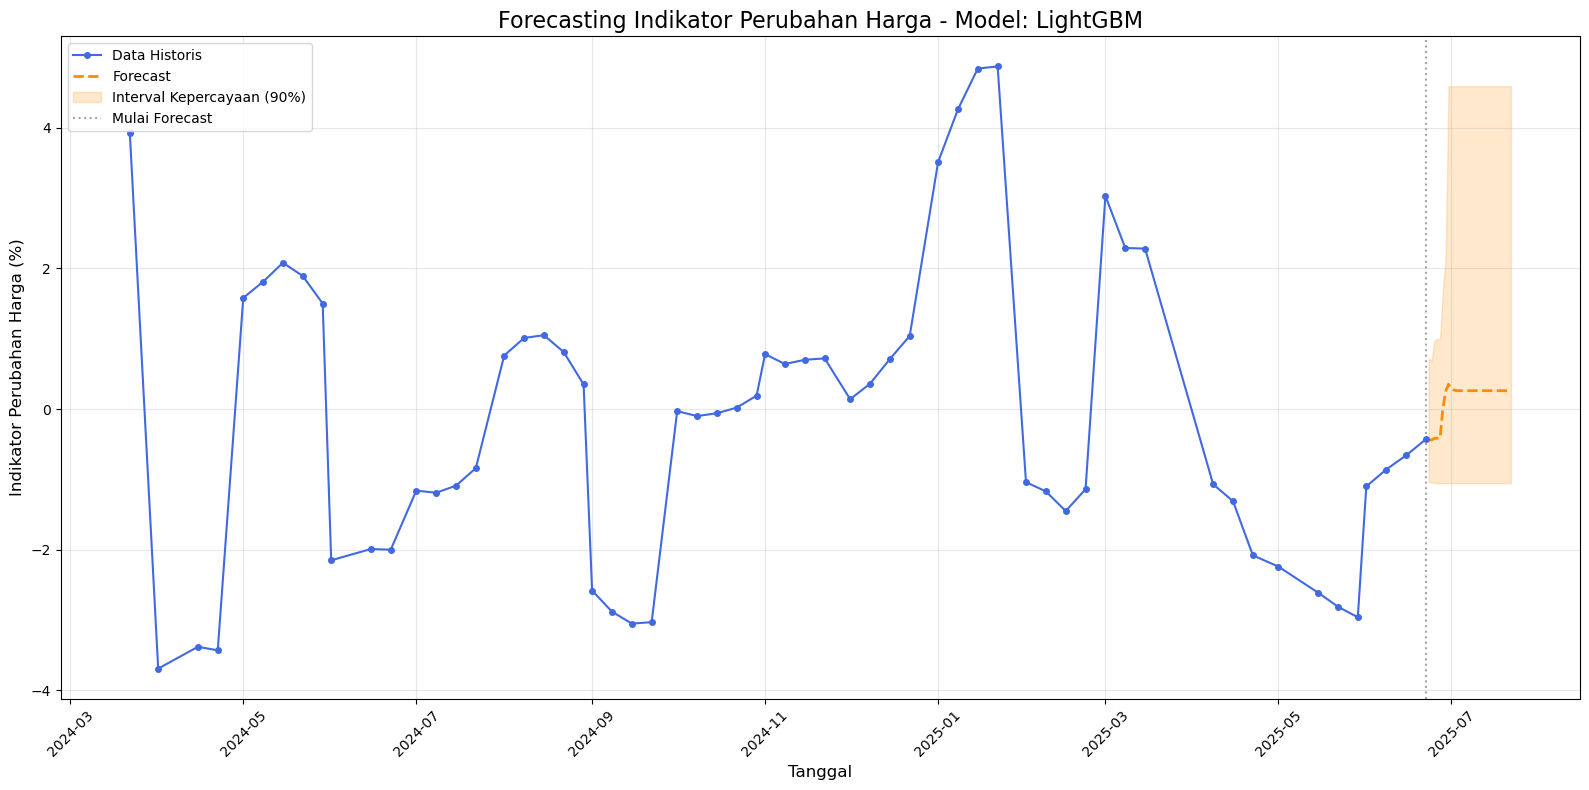


Statistik Forecast LightGBM:
Rata-rata forecast: 0.14
Std forecast: 0.26
Min forecast: -0.44
Max forecast: 0.35
Trend: Naik

--- Memproses Model: XGBoost_Advanced ---


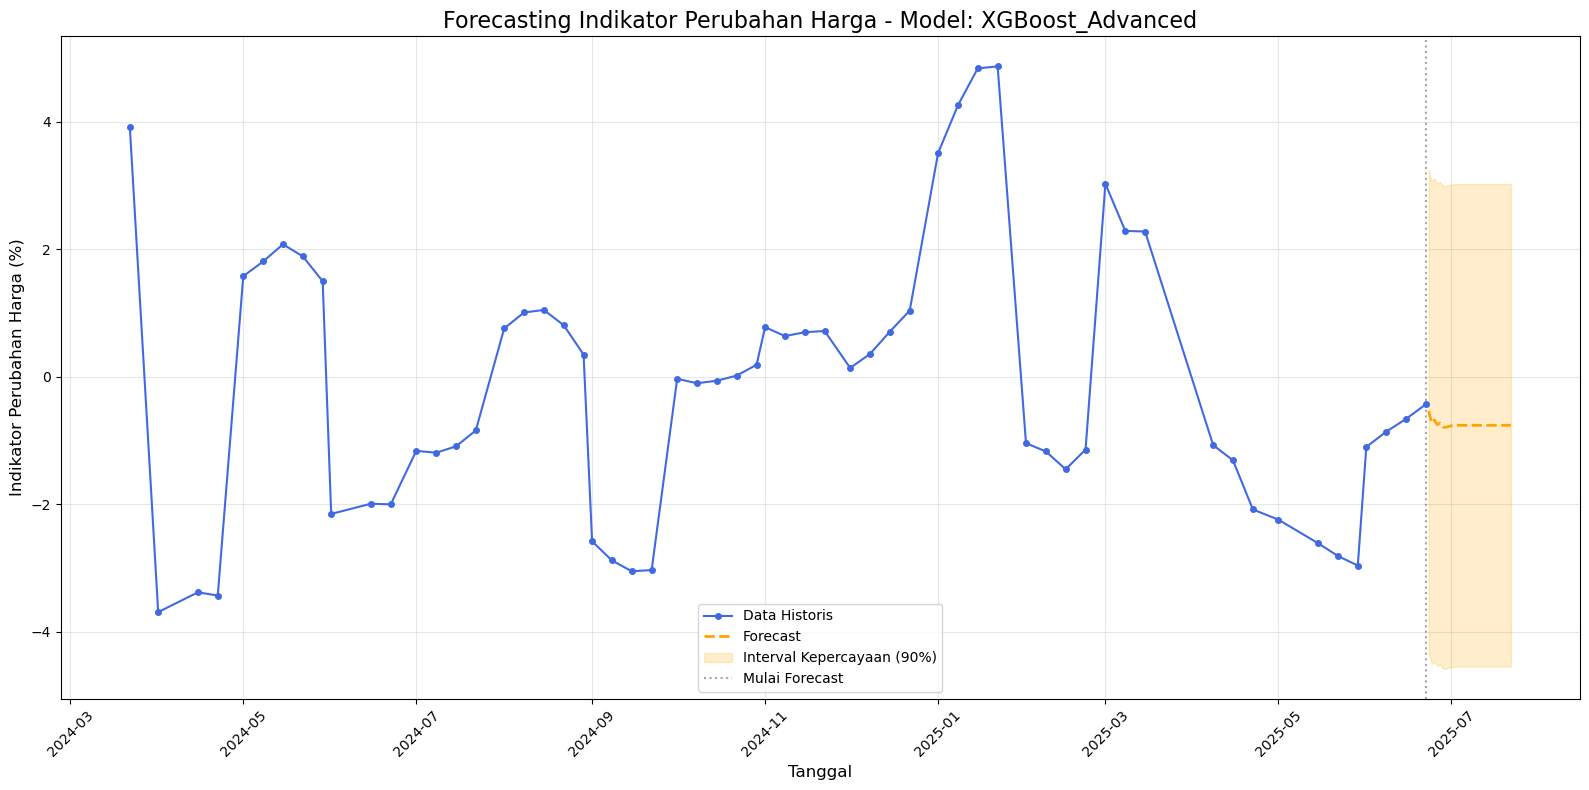


Statistik Forecast XGBoost_Advanced:
Rata-rata forecast: -0.75
Std forecast: 0.04
Min forecast: -0.79
Max forecast: -0.54
Trend: Turun


In [38]:
# Gabungkan data train dan test untuk mendapatkan data terbaru
all_data = pd.concat([train_df, test_df]).sort_values('Tanggal').reset_index(drop=True)

# Tentukan berapa langkah ke depan yang ingin diprediksi
FORECAST_STEPS = 30  # Prediksi 30 hari ke depan

# Dapatkan tanggal terakhir dan buat tanggal forecast
last_date = all_data['Tanggal'].max()
forecast_dates = pd.date_range(start=last_date + timedelta(days=1), periods=FORECAST_STEPS, freq='D')

# Dapatkan fitur terakhir untuk memulai forecasting
last_features = all_data[FEATURE_COLS].iloc[-1].values

# Gabungkan semua data untuk training
X_all = all_data[FEATURE_COLS].values
y_all = all_data[TARGET_COL].values

## Loop melalui setiap model untuk membuat prediksi dan visualisasi
forecast_results_all = {}

for name, model in models.items():
    try:
        print(f"\n--- Memproses Model: {name} ---")
        
        # Latih ulang model dengan semua data yang tersedia
        model.fit(X_all, y_all)
        
        # Lakukan forecasting
        if name == 'KNN':
            y_forecast = forecast_multistep(model, last_features, FORECAST_STEPS, FEATURE_COLS)
            y_forecast_lower = y_forecast
            y_forecast_upper = y_forecast
            
        elif name == 'Random Forest':
            # Untuk Random Forest, kita bisa mendapatkan uncertainty dari variasi antar trees
            individual_forecasts = []
            for tree in model.estimators_:
                tree_forecast = []
                current_features = last_features.copy()
                for step in range(FORECAST_STEPS):
                    pred = tree.predict(current_features.reshape(1, -1))[0]
                    tree_forecast.append(pred)
                    # Update features
                    new_features = np.zeros_like(current_features)
                    new_features[0] = pred
                    for i in range(1, 4):
                        if i < len(current_features):
                            new_features[i] = current_features[i-1]
                    new_features[4] = np.mean([pred, current_features[0], current_features[1]])
                    new_features[5] = np.mean(current_features[:4])
                    current_features = new_features
                individual_forecasts.append(tree_forecast)
            
            individual_forecasts = np.array(individual_forecasts)
            y_forecast = np.mean(individual_forecasts, axis=0)
            y_forecast_lower = np.percentile(individual_forecasts, 5, axis=0)
            y_forecast_upper = np.percentile(individual_forecasts, 95, axis=0)
            
        elif name == 'LightGBM':
            # Untuk LightGBM, gunakan quantile regression
            params = model.get_params()
            # Hapus parameter yang mungkin konflik
            params.pop('objective', None)
            params.pop('verbose', None)
            
            # Buat model quantile regression
            lgbm_median = LGBMRegressor(objective='quantile', alpha=0.5, **params)
            lgbm_lower = LGBMRegressor(objective='quantile', alpha=0.05, **params)
            lgbm_upper = LGBMRegressor(objective='quantile', alpha=0.95, **params)
            
            # Fit model
            lgbm_median.fit(X_all, y_all)
            lgbm_lower.fit(X_all, y_all)
            lgbm_upper.fit(X_all, y_all)
            
            # Forecast
            y_forecast = forecast_multistep(lgbm_median, last_features, FORECAST_STEPS, FEATURE_COLS)
            y_forecast_lower = forecast_multistep(lgbm_lower, last_features, FORECAST_STEPS, FEATURE_COLS)
            y_forecast_upper = forecast_multistep(lgbm_upper, last_features, FORECAST_STEPS, FEATURE_COLS)
            
        elif name == 'XGBoost_Advanced':
            # Untuk XGBoost Advanced, gunakan forecasting dengan confidence interval
            y_forecast = forecast_multistep(model, last_features, FORECAST_STEPS, FEATURE_COLS)
            historical_std = np.std(y_all)
            y_forecast_lower = y_forecast - 1.96 * historical_std
            y_forecast_upper = y_forecast + 1.96 * historical_std
        
        # Simpan hasil forecast
        forecast_results_all[name] = {
            'forecast': y_forecast,
            'lower': y_forecast_lower,
            'upper': y_forecast_upper
        }
        
        # --- Visualisasi ---
        plt.rcParams['figure.facecolor'] = 'white'
        plt.rcParams['axes.facecolor'] = 'white'
        plt.rcParams['axes.grid'] = True
        plt.rcParams['grid.alpha'] = 0.3
        
        plt.figure(figsize=(16, 8))
        
        # Plot data historis (sample dari 60 hari terakhir untuk clarity)
        historical_data = all_data.tail(60)
        plt.plot(historical_data['Tanggal'], historical_data[TARGET_COL], 
                 label='Data Historis', color='royalblue', marker='o', markersize=4, zorder=5)
        
        # Plot forecast
        color = 'orange' if name == 'XGBoost_Advanced' else 'darkorange'
        plt.plot(forecast_dates, y_forecast, 
                 label='Forecast', color=color, linestyle='--', linewidth=2, zorder=4)
        
        # Plot uncertainty interval
        if name != 'KNN':
            plt.fill_between(forecast_dates, y_forecast_lower, y_forecast_upper, 
                            color=color, alpha=0.2, label='Interval Kepercayaan (90%)')
        
        # Tambahkan garis vertikal untuk memisahkan historis dan forecast
        plt.axvline(x=last_date, color='gray', linestyle=':', alpha=0.7, label='Mulai Forecast')
        
        plt.title(f'Forecasting Indikator Perubahan Harga - Model: {name}', fontsize=16)
        plt.xlabel('Tanggal', fontsize=12)
        plt.ylabel('Indikator Perubahan Harga (%)', fontsize=12)
        plt.xticks(rotation=45)
        plt.legend(loc='best')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Tampilkan statistik forecast
        print(f"\nStatistik Forecast {name}:")
        print(f"Rata-rata forecast: {np.mean(y_forecast):.2f}")
        print(f"Std forecast: {np.std(y_forecast):.2f}")
        print(f"Min forecast: {np.min(y_forecast):.2f}")
        print(f"Max forecast: {np.max(y_forecast):.2f}")
        print(f"Trend: {'Naik' if y_forecast[-1] > y_forecast[0] else 'Turun'}")
        
    except Exception as e:
        print(f"Error dengan model {name}: {str(e)}")
        continue

## Simpan hasil forecast



Hasil forecast telah disimpan ke 'hasil_forecast.csv'

Hasil Forecast (5 hari pertama):
     Tanggal  Forecast_KNN  Forecast_Random Forest  Forecast_LightGBM  \
0 2025-06-23       -0.8252               -0.622405          -0.452473   
1 2025-06-24       -0.4800               -0.698599          -0.649221   
2 2025-06-25       -0.1026               -0.784768          -0.750209   
3 2025-06-26       -0.2104               -0.847643          -0.679461   
4 2025-06-27       -0.0258               -0.922561          -0.679461   

   Forecast_XGBoost_Advanced  
0                  -0.535543  
1                  -0.720902  
2                  -0.676057  
3                  -0.749672  
4                  -0.725145  


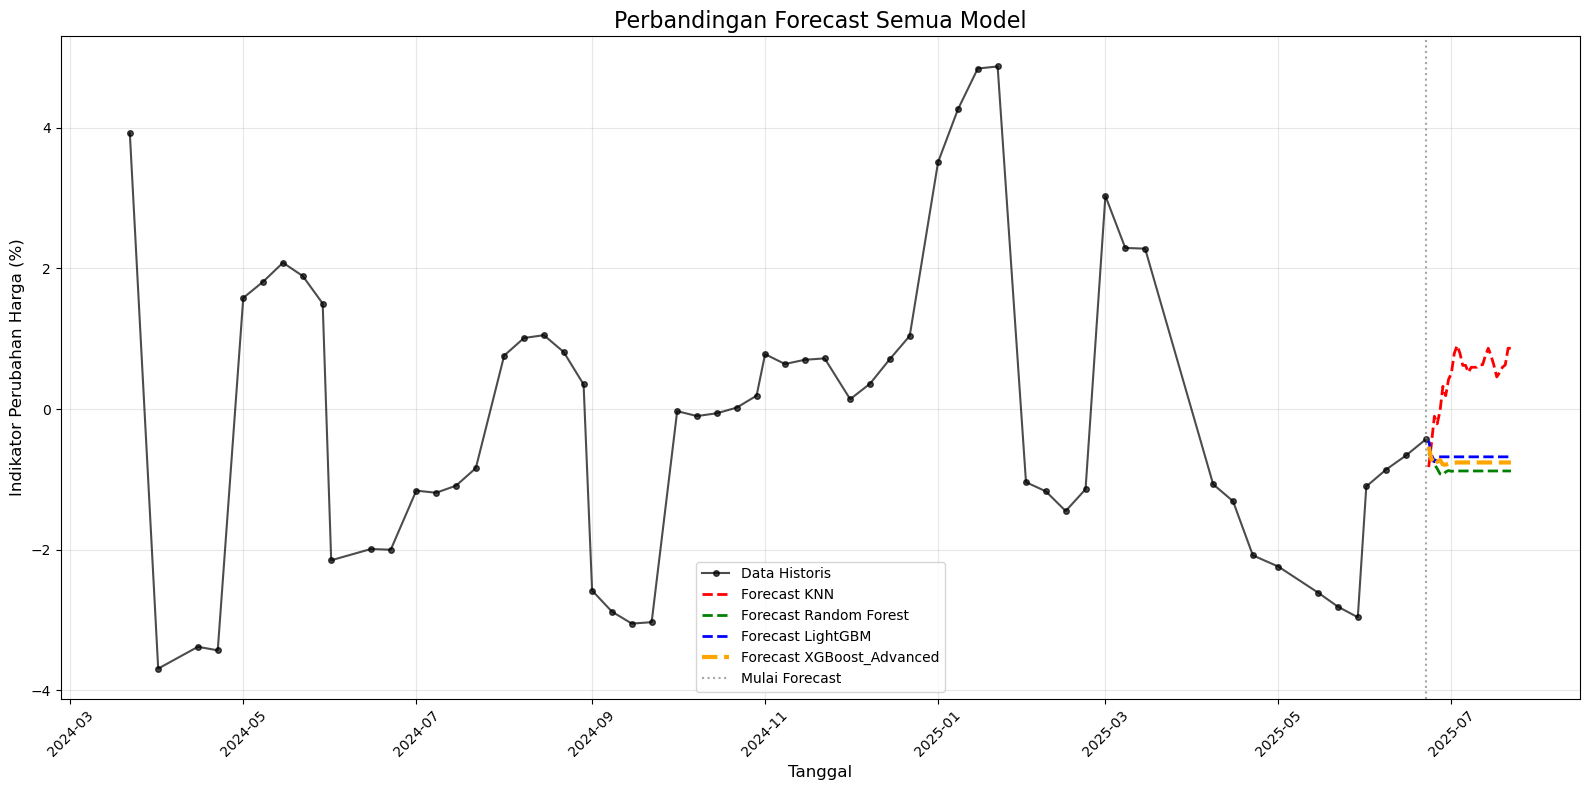


--- Ringkasan Perbandingan Forecast ---
                      Mean       Std       Min       Max
KNN               0.467080  0.413438 -0.825200  0.902600
Random Forest    -0.865199  0.061050 -0.936953 -0.622405
LightGBM         -0.673245  0.044055 -0.750209 -0.452473
XGBoost_Advanced -0.749734  0.045223 -0.791385 -0.535543


In [39]:
forecast_results = pd.DataFrame({
    'Tanggal': forecast_dates
})

# Simpan forecast dari setiap model
for name, model in models.items():
    try:
        # Re-train dan forecast untuk menyimpan hasil
        model.fit(X_all, y_all)
        y_forecast = forecast_multistep(model, last_features, FORECAST_STEPS, FEATURE_COLS)
        forecast_results[f'Forecast_{name}'] = y_forecast
    except Exception as e:
        print(f"Error forecasting {name}: {str(e)}")
        continue

# Simpan ke CSV
forecast_results.to_csv('hasil_forecast.csv', index=False)
print("\nHasil forecast telah disimpan ke 'hasil_forecast.csv'")

# Tampilkan beberapa baris pertama hasil forecast
print("\nHasil Forecast (5 hari pertama):")
print(forecast_results.head())

## Visualisasi perbandingan semua model

plt.figure(figsize=(16, 8))

# Plot data historis
historical_data = all_data.tail(60)
plt.plot(historical_data['Tanggal'], historical_data[TARGET_COL], 
         label='Data Historis', color='black', marker='o', markersize=4, alpha=0.7)

# Plot forecast dari setiap model
colors = ['red', 'green', 'blue', 'orange']
for i, name in enumerate(models.keys()):
    if f'Forecast_{name}' in forecast_results.columns:
        color = 'orange' if name == 'XGBoost_Advanced' else colors[i % len(colors)]
        linewidth = 3 if name == 'XGBoost_Advanced' else 2
        plt.plot(forecast_dates, forecast_results[f'Forecast_{name}'], 
                 label=f'Forecast {name}', color=color, 
                 linestyle='--', linewidth=linewidth)

# Tambahkan garis pemisah
plt.axvline(x=last_date, color='gray', linestyle=':', alpha=0.7, label='Mulai Forecast')

# Formatting
plt.title('Perbandingan Forecast Semua Model', fontsize=16)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Indikator Perubahan Harga (%)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Tampilkan ringkasan perbandingan forecast
print("\n--- Ringkasan Perbandingan Forecast ---")
summary_stats = {}
for name in models.keys():
    col_name = f'Forecast_{name}'
    if col_name in forecast_results.columns:
        summary_stats[name] = {
            'Mean': forecast_results[col_name].mean(),
            'Std': forecast_results[col_name].std(),
            'Min': forecast_results[col_name].min(),
            'Max': forecast_results[col_name].max()
        }

summary_df = pd.DataFrame(summary_stats).T
print(summary_df)

## Simpan Model dan Hasil dalam Format PKL


In [41]:
def list_saved_models(folder='saved_models'):
    """
    Menampilkan daftar semua model yang tersimpan
    """
    if not os.path.exists(folder):
        print(f"Folder '{folder}' tidak ditemukan.")
        return []
    
    model_files = [f for f in os.listdir(folder) if f.endswith('.pkl')]
    
    if not model_files:
        print("Tidak ada model yang tersimpan.")
        return []
    
    print(f"\nDaftar model yang tersimpan di '{folder}':")
    for i, file in enumerate(model_files, 1):
        model_name = file.replace('.pkl', '').replace('_', ' ')
        print(f"{i}. {model_name}")
    
    return model_files

def get_model_info(model_name, folder='saved_models'):
    """
    Mendapatkan informasi detail model
    """
    model_data = load_individual_model(model_name, folder)
    
    if model_data:
        print(f"\nInformasi Model: {model_name}")
        print("=" * 50)
        print(f"Nama Model: {model_data['model_name']}")
        print(f"Waktu Training: {model_data['training_timestamp']}")
        print(f"MAE: {model_data['model_info']['MAE']:.4f}")
        print(f"RMSE: {model_data['model_info']['RMSE']:.4f}")
        print(f"R²: {model_data['model_info']['R²']:.4f}")
        print(f"Training Time: {model_data['model_info']['Training_Time']:.2f}s")
        print(f"Model Type: {model_data['model_info']['Model_Type']}")
        print(f"Feature Columns: {model_data['feature_cols']}")
        
        return model_data['model_info']
    
    return None

# Demonstrasi utility functions
print(f"\n{'='*80}")
print("DEMONSTRASI UTILITY FUNCTIONS")
print(f"{'='*80}")

# List semua model yang tersimpan
list_saved_models()


DEMONSTRASI UTILITY FUNCTIONS

Daftar model yang tersimpan di 'saved_models':
1. KNN
2. LightGBM
3. Random Forest
4. XGBoost Advanced


['KNN.pkl', 'LightGBM.pkl', 'Random_Forest.pkl', 'XGBoost_Advanced.pkl']